# まとめ
ノイズの多いテキストデータを良い回答，悪い回答に分類するにはどうすれば良いか？という問題に取り組んだ．  
使用したデータはstackoverflowの問答データ．教師データになりそうなのはScore．  
以降の分類器はscikit-learnに便利な関数が多数用意されている．  

- K近傍法による分類
    - 特徴量を増やしたり，Kの値を大きくしてモデルを単純にしても，時間がかかるだけで精度が上がらないことがある．  
    - モデルを単純にしても特徴量を改良してもバリアンスが高いので，K近傍法はこのタスクに向かないとわかった．
        - バイアス-バリアンストレードオフ
            - (エラーの)バイアスが高い->未学習, 訓練誤差もテスト誤差も大きい, データのノイズが多い， 特徴量の設計がマズい
            - バリアンスが高い->過学習, 訓練誤差とテスト誤差の差が大きい, モデルが複雑すぎる
            - これらはトレードオフであり，最適解を探したい
- ロジスティック回帰による分類
    - ロジスティック回帰: どんな入力にも白か黒かの確率を返す関数の回帰による最適化
        - 要は「オッズ比の対数関数の逆関数に入力する線形式の最適化」
        - オッズ比：$P/(1-P)$
        - 入力無限領域，出力0~1の確率の形にできる
        - 1次式を入力するシグモイド関数とも言える
        - バイアス+ 係数 ＊ 特徴量の値 + 係数 ＊ 特徴量の値 + ... をロジスティック回帰の式に入力することでクラスに属する確率を得る
        - 正規化パラメータCがある
    - 最適なCを選んでも，90NNと同じくらいの精度しか出ない．
        - バイアスが大きい
    - 悪い回答か良い回答のどちらかがわかれば良いのでは?
    - 適合率-再現率曲線(Precision-Recall curve)のAUC(Area Under Curve)がもっとも大きい閾値を求める
        - 適合率： $TP / (TP + FP)$ 冤罪を起こさない確率
        - 再現率: $ TP / (TP + FN) $ 犯人を逃さない確率
        - 適合率と再現率はトレードオフ． 再現率をあげてもどれだけ適合率が下がらないかをグラフでみるのが適合率-再現率曲線
    - 結果として，良い回答かどうかを分類する方が，悪い回答かどうかを分類するより高いAUCを出せることがわかった．  
    - ロジスティック係数が0に近い特徴量は分類器の精度にあまり影響を与えないので省ける
    - このモデルをで保存しておくことで，Webサービスなどでは素早く回答の良し悪しを判別させられる．
        

注意!!
Chapter 5 - Classification - Detecting Poor Answers
===================================================

The book chapter is based on StackExchange's data blob from August 2012 for the first edition. 

After publishing the book, StackExchange released the May 2014 version at
[https://archive.org/download/stackexchange/stackexchange_archive.torrent](https://archive.org/download/stackexchange/stackexchange_archive.torrent).

Note that using the latest version, you will get slightly different results.

The code is using pyenchant for spell correction. Pyenchent is only used to increase your pleasure of eperimenting with additional features. It is not used later on the chapter. So, if you find out that your platform poses too big problems to install it (e.g. on 64bit Windows), don't bother.

stackoverflowのようなサイト上での質問への回答が良いものかどうかを投稿前に評価してくれる仕組みを作成したい．  
<br>
難しいのは，100%の正解率を達成するような方法が存在しないということと，回答の内容が良いかどうかという指標は人によって分かれる，ということ．  
この章では，最近傍法→ロジスティック回帰→最終的にどの手法を選択すれば良いか ということについて述べていく

# 良い回答を分類する
ラベルづけをまず行いたい．  
- データをどのように表現すべきか?
- 分類器はどのようなモデル，または構造にすべきか？

ということに気をつけながらラベリングを行なっていく．  

## データの表現方法
テキストデータそのものは機械学習アルゴリズムでは扱えないので，有効な特徴量となる数値を我々が自分の手で抽出する必要がある．

## 使用する分類器
テキストとラベル(ここでは，回答が受理されたかどうか)のペアを使って，分類器を訓練できる．  
- ロジスティック回帰
- 決定木
- SVM
- ナイーブベイズ

といった分類がある．  
これまでは，事例に基づく(instance-based)学習であったが,本章では，モデルベースの手法であるロジスティック回帰を利用する．  
ここで，インスタンスベースの手法とは，訓練データとして用いた事例をそのまま覚えて利用する手法．新しい事例に対してはもっとも類似した訓練データの事例を使う．例えば最近傍法など．

# データを用意する
stackoverflowのデータを利用する．  
https://archive.org/details/stackexchange  
Download optionsのtorrent?  
どうもマジでtorrentで入れないといけないみたい  
posts.xmlを使う．  
1つのrowタグには1つの質問もしくは回答が含まれる．  
属性は以下  
- Id: ユニークなID
- PostTypeId: 投稿文書の種類，質問なら1, 回答なら2
- ParentId: 回答の対象ID,質問にはついていない
- CreationDate：投稿日時
- Score: 投稿データのスコア
- ViewCount: 閲覧数
- Body: 投稿内容のHTML
- OwnerUserId: 投稿したユーザのID，1のとき，Wikiに関する質問であることを示す
- Title: 質問のタイトル，回答にはない
- AcceptedAnswerId: 受理された回答のIDを示す．回答にはない
- CommentCount: 投稿データに対してコメントされた回数を示す



## 実験サイクルを早めるためにエータサイズを削減する
Creation Dateが2011年以降のものに限定し，600万程度の投稿データに絞る．  
ファイルをXML形式から必要な情報を抜き出し，TSVにする．

## 必要な属性の選別
ID, PostTypeId, ParentID, CreationDate, Score, Body(プレーンテキストに変換), AcceptedAnswerId(IsAccepted属性を追加)  
具体的なパースの詳細はso_xml_to_tsv.py, choose_instance.py, meta.json(文書IDと他のデータの対応辞書)を参照

parse XML Code

In [1]:
def fetch_posts():
    for line in open("./data/stack_over_flow_data.tsv", "r"):
        post_id, text = line.split("\t")
        yield int(post_id), text.strip()

## 良い回答を定義する
受理された回答が丁寧でわかりやすいかというとそうでもない  
相対的なスコアは，1000のスコアをとった回答があるとき，500は悪い回答なのか，という問題がでてくる．  
ここでは，スコアが0より大きければ良い回答，0以下であれば悪い回答としてみる．  

In [ ]:
all_answers = [q for q, v in meta.iteritems() if v['ParentId'] != -1]
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

# 最初の分類器を作成する
最近傍法はデータをそのまま学習できる美しい手法であるが，これが欠点となることもある．  

## k近傍法からスタートする
sklearnのツールキットを利用する．

In [2]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=2)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')


2近傍法のインスタンスを生成  
試しに使ってみる

In [5]:
train_data = [[1], [2], [3], [4], [5], [6]]
train_label = [0, 0, 0, 1, 1, 1]
knn.fit(train_data, train_label)
print(knn.predict([[1.5]])) # 2次元配列を渡すらしい
print(knn.predict([[37]]))
print(knn.predict([[3]]))

# 結果に対する確率
print(knn.predict_proba([[1.5]]))
print(knn.predict_proba([[37]]))
print(knn.predict_proba([[3.5]]))

[0]
[1]
[0]
[[1. 0.]]
[[0. 1.]]
[[0.5 0.5]]


## 特徴量について模索する
リンクの個数が良い回答を得る特徴量？という仮説

In [ ]:
import re
code_match = re.compile('<pre>(.*?)</pre>', re.MUTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    link_count_in_code = 0
    # コード中に存在するリンクをカウントする
     for matvch_str in code_match.findall(s):
            link_count_in_code += len(link_match.findall(match_str))
    return len(link_match.findall(s)) - link_count_in_code

HTMLの構文解析にはBeautiful soupを使った方がいいんだけどね

リンクの個数を調べてみると，7割の回答にはリンクがないことがわかる．  
これでは良い分類器を作成することはできないが，あえてこの特徴量から分類器を作ってみたい．

## 分類器の訓練を行う
先ほど定義したように，Y=良い回答かどうか(Scoreが1以上)とし,対応する特徴量としてX＝リンクの数を入れてKNN分類器に入力する  

In [ ]:
X = np.asarray([extract_features_from_body(text) for post_id, text in fetch_posts() if post_id in all_answers])
knn = neighbors.KNeiborsClassifier() # デフォルトでK＝5．これが良いかはあとで考える
knn.fit(X, Y)

## 分類器の評価を行う
テストデータに対して正しく予測した割合（Accuracy)を計算することで評価を行う．  
これはknn.score()で求めることができる．  
交差検定(データを分割してテストデータとして用い,正解率の平均をとる)は，sklearn.cross_validationのKFoldクラスでできる．  
標準偏差もとる．

In [ ]:
from sklearn.cross_validation import KFold

scores = []
cv = KFold(n=len(X), k=10, indices=True)
for train, test in cv:
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X, Y)
    scores.append(clf.score(X_test, Y_test))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f" % (np.mean(scores, np.std(scores))))

結果は49%程度でしかなく，コインを投げて予測した方がまだまし，というレベル．  
文書中にあるリンクの数は質を計測するための良い指標ではないことがわかった．

## より多くの特徴量をデザインする
次は文書中のソースコードの行数を特徴量にしてみる  
また，ソースコード以外の単語の数も指標にしてみる

In [ ]:
# ソースコード以外の単語数， ソースコードの行数， リンクの個数を特徴量として返す
def extract_features_from_body(s):
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s
    
    # ソースコードを取り除き，その行数を数える
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub("", code_free_s)
        # ソースコードにはリンクが含まれることがあり，その場合はカウントしない
        link_count_in_code += len(link_match.findall(match_str))
    
    links = link_match.findall(s)
    link_count = len(links)
    link_count -= link_count_in_code
    
    html_free_s = re.sub(" +", " ", tag_match.sub('', code_free_s)).replace("\n", "")
    link_free_s = html_free_s
    
    # 単語の数をカウントする前にリンクを削除する
    for link in links:
        if link.lower().startwith("http://"):
            link_free_s = link_free_s.replace(link, '')
        
        num_text_tokens = html_free_s.count(" ")
    
    return num_text_tokens, num_code_lines, link_count

特徴量の傾向をグラフ化してみると，単語の数はソースコードの行数よりも変化に富んでいることがわかる．  
<br>
これらの特徴量で正解率を計算してみると，スコアは0.58程度になり，すこしだけ正解率を改善することができた．  
しかし，まだまだスコアは低い．  
そこで特徴量を他にも増やしてみればいいと思いつくが，うまくは行かない．  
<br>
原因の一つに，どのパラメータも同じ重みで計算されていることがある．  
例えば，リンクの数は1つでもあれば良いが，単語の数は10個も20個もあまり変わりはない．  
この考察から，今扱っているデータに対してk近傍法ではうまく分類できない．(? 重みパラメータを与えてやればいいのでは？)

# 改善案について考える
改善策として，以下のようなものがある．  
- データを追加する
- モデルの複雑さを調整する(kを変化させたり)
- 特徴量を修正する(スケール変更，新しい特徴量の追加，不要な特徴量の削除など)
- モデルを変更する(kNNは適していない?)

これらの方法から手当たり次第にうまくいきそうな方法を探していては時間がかかる．  
そこで，情報に基づく決定を行うための「バイアス-バリアンスのトレードオフ(bias-variance tradeoff」を紹介

## バイアス-バリアンスのトレードオフ
1章でみたように，次元が低すぎると未学習を起こす．この状態をデータに対して「バイアスが大きすぎる」と表現する．  
また，次元が大きすぎると過学習を起こし，汎化性に欠ける．この状態をデータに対して「バリアンスが大きすぎる」と表現する．  
この2つのトレードオフの間にある最適解を見つけたい．

## バイアスが大きい場合の対処法
つまり，複雑性が低すぎる場合．この場合，
- 特徴量を増やす
- モデルをより複雑なものにする
- モデルを変更する

といった対処を行う

## バリアンスが大きい場合の対処法
つまり，モデルが複雑すぎ流場合． この場合，
- より多くのデータを集める
- モデルの複雑さを減らす
    - kの値を増加させる(減らすんじゃないらしい)
- 特徴量の数を減らす

## バイアスは大きい？小さい？
まず，データサイズを変化させた時の訓練データの誤差(訓練誤差)とテストデータの誤差(テスト誤差)をプロットする．  
バイアスが大きい→データサイズが大きくなるにつれて，訓練誤差とテスト誤差の値は共に大きい値に落ち着く
バリアンスが大きい→訓練誤差とテスト誤差の示すグラフの曲線に大きな隔たりがある．  
<br>
5近傍法において，今回の問題のデータサイズを増加した場合の訓練誤差とテスト誤差をプロットすると，2つの曲線には大きな隔たりがある．  
すなわち，これはバリアンスが大きいことが問題になっていることがわかる．  
これは特徴量を減らしてみても変わらない．  
<br>
なので，モデルの複雑性を下げるために，kの値を90まであげてみる．  
すると，スコアは0.68程度になり，より良い結果を得られる．  
しかし，この場合90個の近傍店を見つける必要があり，かなりの時間がかかる．  

今回のタスクにk近傍法を使うことには何かしら問題がある．  
- 複雑性を下げようとすると時間がかかる
- 文書の数が増えるほど分類にかかる時間が長くなる

こういった問題は，インスタンスベースの学習であるために起きることが多い．  
そこで，テキスト分類の場面で威力を発揮する，モデルベースのアプローチを紹介する．

# ロジスティック回帰を用いる
回帰とは言っているが，分類に関する手法である．  
テキストベースの分類問題で威力を発揮する．  
ロジスティック関数で回帰を行い，その結果から分類をおこなうため，この名前がつけられた．

## ロジスティック回帰の簡単な例
データセットを人工的に作る

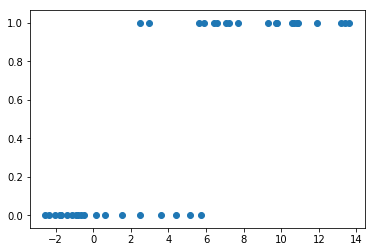

In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt

ones = [random.uniform(1, 14) for i in range(20)]
zeros = [random.uniform(-3, 6) for i in range(20)]
X = ones + zeros
Y = np.hstack((np.ones(20, dtype='i'), np.zeros(20, dtype='i')))
plt.scatter(X, Y)

こういったデータは，あるデータの予測値が0か1かの離散的な値を直接出力するより，ある特徴量Xがクラス1に属する確率をP(X)としてモデル化した方が良い． 確率が0.5より大きければ1に，そうでなければ0に分類できる．

ある関数について，その出力値を有限範囲に収まるようにモデル化することは数学的に難しい．  
ここでは確率関数を調整することで，出力値を常に0~1の間に収まるようにする．  
そのために，オッズ比(odds ratio)とその対数が必要  
ここでオッズ比とは，ある事象の起きる確率(P)とある事象が起きない確率(1-P)の比，つまり$ \frac{P}{P-1}$のこと．

例えば，ある特徴量について，それがクラス1に属する確率が0.9の場合，つまりP(y=1) = 0.9の場合を考える．  
この時オッズ比は$\frac{0.9}{0.1} = 9$これは，この特量量を持つデータが9:1の可能性でクラス1に属すると言える．  
もしP(y=0.5)ならば，1:1の可能性になる．オッズ比が取りうる値の範囲は0~∞になる．  
今ここでこのオッズ比について対数をとると，確率値が0~1をとる場合，それを-∞~+∞の範囲に変換できる．  
この良い点としては，確率値が大きくなるにしたがい，その対数の値も大きくなるという関連性が保たれているということ．  
そして，この逆数をとると，それは[-∞, ∞] -> [0, 1]の有限範囲を出力する関数になる．

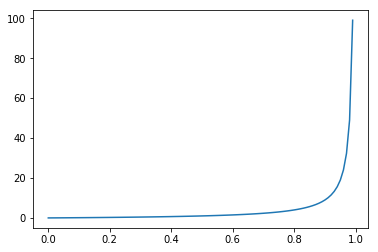

In [45]:
# オッズ比のグラフ
P = np.arange(0, 1, 0.01)
odds = P / (1 - P)
plt.plot(P, odds)

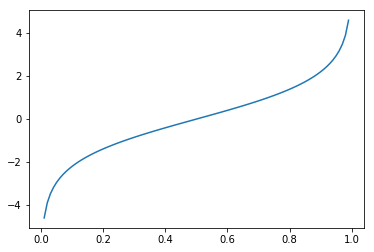

In [46]:
# オッズの対数をとる関数
import math
logodds = [math.log(o) for o in odds[1:]] # log2(0)はエラー
plt.plot(P[1:], logodds) 

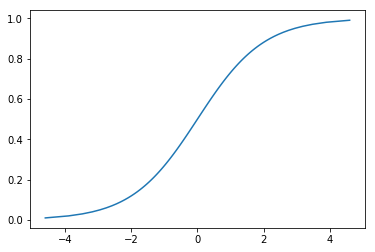

In [48]:
# オッズ比の対数関数の逆関数
# 入力を無限の範囲に取り，0~1の値を出力する関数にできる
plt.plot(logodds, P[1:])

ここでは，特徴量がXの1次元のみなので，これについて特徴量の線形な組み合わせの方程式をまず書いてみる
$$ y_i = c_0 + c_1 x_i $$
この$y_i$を$\log(odds)$に置き換えると
$$ \log \Bigr( \frac{p_i}{1 - p_i} \Bigl) = c_0 + c_1 x_i $$
さらに，$p_i$について解を求める
$$ \frac{p_i}{1 - p_i} = \exp(c_0 + c_1 x_i) $$
$$ p_i = \exp(c_0 + c_1 x_i) - \exp(c_0 + c_1 x_i) p_i $$
$$ ( 1 + \exp(c_0 + c_1 x_i) )p_i = \exp(c_0 + c_1 x_i) $$
$$ p_i = \frac{ \exp(c_0 + c_1 x_i) }{ 1 + \exp(c_0 + c_1 x_i) }$$
$$ p_i = \frac{ 1 }{ 1 + e^{-(c_0 + c_1 x_i)} }$$
この得られた$p_i$の$c_0, c_1$を，全てのペアデータ($x_i$, $p_i$)に対して誤差が最小になるように最適化する．  
これがロジスティック回帰である．  
が，式の形から見てわかるように，結局はシグモイド関数である．  
シグモイド関数の入力に渡す値の重みを調整し，白か黒かの確率を出力することとこのロジスティック回帰は等価である．  
sklearnによってこの最適化作業を簡単に行うことができる．

In [81]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs') # Specifyしないとワーニング吐かれる
print(clf)

clf.fit(np.array(X).reshape(-1, 1), Y)
print("parameters:", np.exp(clf.intercept_), np.exp(clf.coef_.ravel())) # intercept_: c0, coef_.ravel(): c1 ~ の係数

def lr_model(clf, X):
    return 1 / (1 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

print("P(x=-1)=%.2f\tP(x=7)=%.2f" % (lr_model(clf, -1), lr_model(clf, 7)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
parameters: [0.03404534] [2.1605334]
P(x=-1)=0.02	P(x=7)=0.88


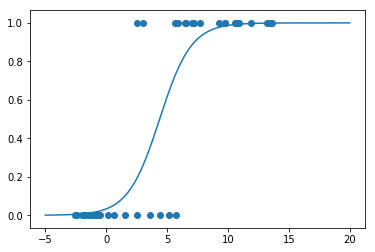

In [96]:
plt.scatter(X, Y)
P = np.arange(-5, 20, 0.01)
plt.plot(P, [lr_model(clf, i).flatten() for i in P])

そしてこのようにして，フィッティングを行なったモデルをグラフに描画することで，データにうまく適合できていることがわかる．

## ロジスティック回帰を今回の問題に適用する
ロジスティック回帰を用いた場合の正解率は，90NNの時とあまり変わらない．  
ここで，ロジスティック回帰のパラメータとしてCがあるが，これはロジスティック回帰で正規化を行うためのパラメータである．  
これを小さくするとモデルは複雑に，大きくするとモデルは単純になる．kNNのkと同じ役割を持つ．  
<br>
C=0.1の時が一番正解率が高いので，このモデルのバイアス-バリアンスについて見てみると，バイアスが大きいことがわかる．  
テスト誤差と訓練誤差を示す線はデータが増えるごとに互いに近づいていくが，共にError=0.4と大きな値を取っている．  
このことから，現在の特徴量に対するロジスティック回帰は未学習であり，データを正しく捉えることができていないと言える，  
<br>
バイアスが大きい原因は，
- データにノイズが含まれすぎている
- 設計した特徴量に問題がある

が挙げられる

# 適合率と再現率
我々は，分類器の評価を行うために，正解率を指標として用いてきたが，実際には回答の良し悪しを完璧に予測する必要はない．  
たとえば，悪い回答であるかどうか，ということだけを分類した方が良い結果が出るかもしれない．  
ここで，適合率と再現率について理解したい．  

|事実|分類器の予測|結果|
|:-:|:-:|:--|
|陽|陽|True positive(TP)|
|陽|陰|False positive(FP)|
|陰|陽|False negative(TN)|
|陰|陰|True negative(FN)|

Trueとついているのが正しいところ，Falseとついているのが間違っているところ  
positiveとついているのが予測結果が陽，negativeとついているのが予測結果が陰  
<br>
分類器が「Positive」と予測した中で，それが正しい割合を計算したものを「適合率(Precision)」と呼ぶ．  
$$ Precision = \frac{TP}{TP + FP} $$
良い回答であると分類された回答の中で実際に良い回答であったものの割合にあたる．  
<br>
一方，事実が「Positive」であるものの中で，予測が正しかったものの割合を「再現率(Recall)」と呼ぶ．
$$ Recall = \frac{TP}{TP + FN} $$
全ての良い回答の中で，良い回答と分類されたものの割合にあたる．

適合率と再現率のより直感的な説明
<br>
システムA：  
検索結果として50件ヒットした。すべてが犬の写真で誤りは1つもなかった。でも、データ群の中には取りこぼした犬の写真が70件あった。  
<br>
システムB：  
検索結果として200件ヒットした。そのうち、80件は誤りだったけど、データ群の中の犬の写真はすべて拾い出した。取りこぼしは0件だった。  
<br>
どちらが優れているかは、その検索の目的によって異なる。  
システムAは適合率 precision が高い。（適合率 1.0、再現率 0.41） -> 少しでも犬じゃないっぽいやつは取り除く， 間違わないが取りこぼす  
システムBは再現率 recall が高い。（適合率 0.6、再現率 1.0） -> 少しでも犬っぽいなら取り込む， 取りこぼさないが間違う  
<br>
犯人を逃がすことがあるが冤罪は起こさない確率 -> 適合率  
冤罪を起こすことがあっても犯人は捕まえる確率 -> 再現率  
<br>
このことからわかるように，適合率と再現率は基本的にトレードオフの関係にある．  
再現率をあげても適合率が下がらないようなシステムが優秀であると言える．  
つまり，犯人をとりこぼさず，かつ冤罪を起こさない警察こそが有能ということ．  
この再現率を横軸，適合率を縦軸に取ったグラフがPrecision-Recall Curve．  
適合率が上がっても(右に行っても)再現率が高い(曲線が上)ようなシステムが良く分類を行えていると言える．

適合率を最適にする方法を考える．  
今のところ，閾値に$p_i = 0.5$という値を用いて回答の良し悪しを判定しているが，これを変更した時の，TP, FP, FNの数を数える．  
それらの値から，再現率と適合率の変移をプロットする．  
sklearnのmetricsモジュールのprecision_recall_curve関数によって，適合率と再現率の計算を行う．  

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict(X_test))

片方のクラス(例えば良い回答)を許容できる制度で分類できたとしても，もう片方のクラスを同じように許容できる制度で分類できるとは限らない．  
良い回答と悪い回答でそれぞれ適合率-再現率曲線(Precision-Recall curve)を書いてみる．  
これらのグラフの曲線下面積（Area Under the Curve)の値が直感的には分類器の平均的な適合率となる．  
良い回答のAUCが0.7程度，悪い回答のAUCが0.62程度なので，良い回答かどうかを判別させた方が良い結果になることがわかる．  
良い回答のAUCは，再現率が0.6程度に上がるまで適合率が0.8を超えており，良い感じである．  

In [ ]:
medium = np.argsort(scores)[len(scores) / 2]
thresholds = np.hstack(([0], thresholds[medium]))
idx80 = precisions >= 0.8
print("P=%.2f R=%.2f thresh=%.2f" % (precision[idx80][0], recall[idx80][0], threshold[idx80][0]))

結果，閾値を0．63に設定すると適合率が80％を超え，その時の再現率は37％であることがわかった．  
これが意味することは，実際に良い回答の1/3に対してだけ判定を下すが，予測結果の8割以上は正しい結果であるということ．  
分類器が予測を行うときにこの閾値（0．63）を適用するためには，predict_proba()メソッドを使う．  
predict()メソッドは各データが属するクラスを返すが，predict_proba()は各データがそれぞれのクラスに属する確率を返す．

In [ ]:
thresh80 = threshold[idx80][0]
probs_for_good = clf.predict_proba(answer_features)[:, 1]
answer_class = probs_for_good > thresh80

classification_reportというモジュールで適合率と再現率の値を確認することができる

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predit_proba[:, 1] > 0.63, target_names=['not accepted', 'accepted']))

ここまでは適切な閾値を求めてきたが，その閾値を用いることで，必ず期待している適合率と再現率を満たすとは限らない

# 分類器をスリムにする
各特徴量が分類を行うためにどれだけ貢献しているか，は回帰係数の値で調べられる．  
clf.coef_によって取得できる回帰係数が，大きいほど重要な特徴量である．  
マイナスの値を持つ回帰係数は「悪い」と分類するときにおける影響が大きくなる．  
これを調べてみると，LinkCountとNumExclamsがもっとも大きな影響力を持つことがわかる．  
一方，回答中の画像の数は回帰係数が0に近いため，使わなくても分類器の性能にはほとんど影響を及ぼさない．  
こういった特徴量は取り除くことができる．

# 完成!
この分類器をWebサイトに組み込むに当たって，アクセスがあるたびに分類器の訓練は行わず，訓練を行なった結果をシリアライズして，サイト上でデシリアライズすることで分類を素早く行う．

In [ ]:
import pickle
pickle.dump(clf, open("logreg.dat", "w")) # 書き込み
clf = pickle.load(open("logreg.dat", "r")) # 読み込み

# まとめ
ノイズが多く含まれるデータセットから，良い回答か悪い回答かの判別を部分的に達成した．  
その過程で，最近傍法とロジスティック回帰の利点，欠点を学ぶことができた．  
また，特徴量の抽出方法を学んだ．  
それぞれの特徴量が分類器の性能にどれだけの影響があるかということを学んだ．  
もっとも重要なのは，分類器の改善法．  